# Travel time to K-Visitations
**Description:**
This notebook reproduces the plots containing the travel time to K-Visitations in the manuscript.

It consists of:
1. **Figure 1b-c:** CDF plots of travel time to K-Visitations using public transport across cities and scenarios. This is supplemented by Figure S11, which considered travel time with private transport. The visualisation operationalised on the aggregated grid-level metrics.
2. **Figure 1d:** Scatter plot of share of population accessible to their K-Visitations within 15 minutes using public transport. 
3. **Figure 1e:** Lineplot to show changes in travel time to K-Visitations across different local POI density deciles. This is operationalised on H3 grid L9.
4. **Figure 1f-g:** Barplot showing the absolute differences in travel time ($\Delta_T = T_{freq} - T_{dist}$), and relative differences ($\Delta_T / T_{dist}$) across local POI density deciles. 

**Data Source:** 
- `data/ttm_grid.csv`: Travel time to K-visitation, aggregated at Finnish 1km grid level to associate with population (Provided in repo).
- `data/ttm_gid9.csv`: Travel time to K-visitation, aggregated at H3 level 9 level to associate with local POI density (Provided in repo).

In [1]:
import sys
import os
from pathlib import Path
import dask.dataframe as dd
import pandas as pd
import numpy as np
from shapely.geometry import Point
import geopandas as gpd
import h3

import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from pypalettes import load_cmap
from matplotlib.colors import LinearSegmentedColormap

import seaborn as sns
from pypalettes import load_cmap

import contextily as ctx

# Setup project root path
project_root = Path.cwd()
if 'notebooks' in str(project_root):
    project_root = project_root.parent

# Set data and results paths
data_dir = project_root / 'data'

sns.set_theme(style='white')

## Fig 1b-c: Travel time to K-visitations by public transport

In [2]:
grid_ttm_combined = pd.read_csv(data_dir / 'ttm_grid.csv')

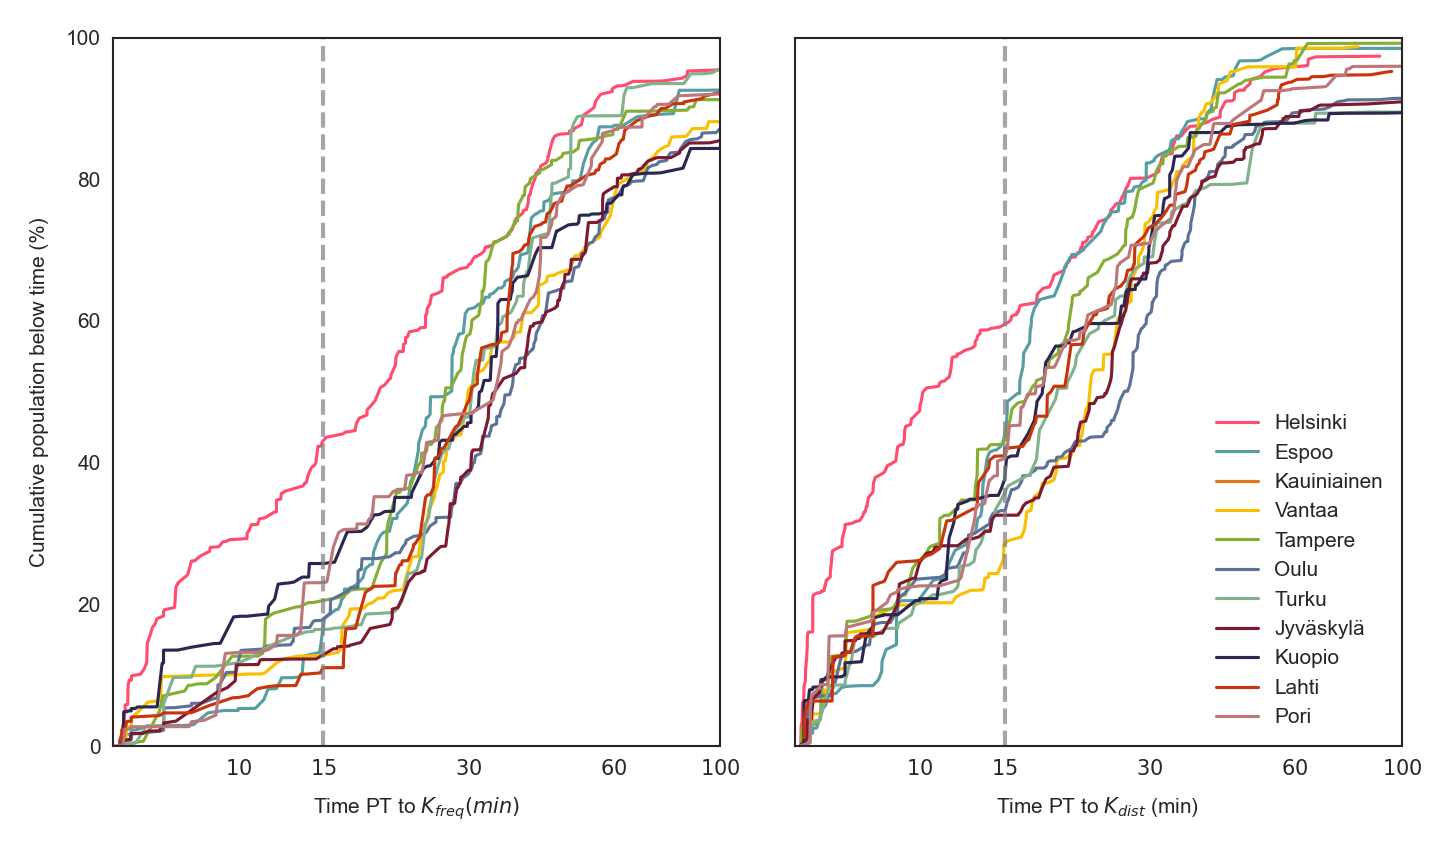

In [3]:
# Figure



fig, subplots = plt.subplots(1, 2, figsize=(5, 3), dpi=300) 

cities = ['Helsinki', 
          'Espoo',
          'Kauiniainen',
          'Vantaa',
          'Tampere', 
          'Oulu', 
          'Turku',
          'Jyväskylä', 
          'Kuopio', 
          'Lahti', 
          'Pori', 
          ]

# Convert the colormap to a list of colors
cmap = load_cmap('Klein')
palette_colors = [cmap(i) for i in np.linspace(0, 1, len(cities))]

for i, city in enumerate(cities):
    # Filter the data for the current city
    city_data = grid_ttm_combined[grid_ttm_combined['city'] == city]

    # Calculate the CDF for the travel time frequency
    freq_data = city_data[['pt_tt_kfreq', 'popu']].sort_values(by='pt_tt_kfreq')
    freq_cdf = np.cumsum(freq_data['popu']) / freq_data['popu'].sum() * 100  # Convert to percentage
    subplots[0].plot(freq_data['pt_tt_kfreq'], freq_cdf, label=city, color=palette_colors[i], linewidth=0.75)

    # Calculate the CDF for the travel time distance
    dist_data = city_data[['pt_tt_kdist', 'popu']].sort_values(by='pt_tt_kdist')
    dist_cdf = np.cumsum(dist_data['popu']) / dist_data['popu'].sum() * 100  # Convert to percentage
    subplots[1].plot(dist_data['pt_tt_kdist'], dist_cdf, label=city, color=palette_colors[i], linewidth=0.75)

# Set log scale for x-axis like in the target figure
subplots[0].set_xscale('log')
subplots[1].set_xscale('log')

# Set limits for the x-axis and y-axis to match target
subplots[0].set_xlim(5.5, 100)  
subplots[1].set_xlim(5.5, 100)
subplots[0].set_ylim(0, 100)
subplots[1].set_ylim(0, 100)

# Customize x-axis ticks to show 10^0, 10^1, 10^2
x_ticks = [10, 15, 30, 60, 100]
x_labels = ['$10$', '$15$', '$30$', '$60$', '$100$']
y_ticks = [0, 20, 40, 60, 80, 100]
subplots[0].set_xticks(x_ticks)
subplots[0].set_xticklabels(x_labels, fontsize=5)
subplots[0].set_yticks(y_ticks)
subplots[0].set_yticklabels(y_ticks, fontsize=5)
subplots[1].set_xticks(x_ticks)
subplots[1].set_xticklabels(x_labels, fontsize=5)
subplots[1].set_yticklabels('', fontsize=5)

# Add legend positioned like in target figure
# subplots[0].legend(loc='lower right', fontsize=12, frameon=False)
subplots[1].legend(loc='lower right', fontsize=5, frameon=False)

# Add a vertical line at 15 minutes
subplots[0].axvline(15, color='gray', linestyle='--', alpha=0.7, linewidth=1)
subplots[1].axvline(15, color='gray', linestyle='--', alpha=0.7, linewidth=1)

# Add labels to the axes - match target figure style
subplots[0].set_xlabel('Time PT to $K_{freq} (min)$', fontsize=5)
subplots[1].set_xlabel('Time PT to $K_{dist}$ (min) ', fontsize=5)
subplots[0].set_ylabel('Cumulative population below time (%)', fontsize=5)

# # Remove top and right spines for cleaner look
for ax in subplots:
    ax.spines['top'].set_linewidth(0.5)
    ax.spines['right'].set_linewidth(0.5)
    ax.spines['bottom'].set_linewidth(0.5)
    ax.spines['left'].set_linewidth(0.5)

    ax.tick_params(axis='both', which='major', pad=1, width=0.5, length=2)
plt.tight_layout()

# plt.savefig('/Users/silver/Desktop/finland-mobility/figures/pt_travel_time_k_places_cdf.svg')

plt.show()

### Fig S11: Travel time to K-visitations by car

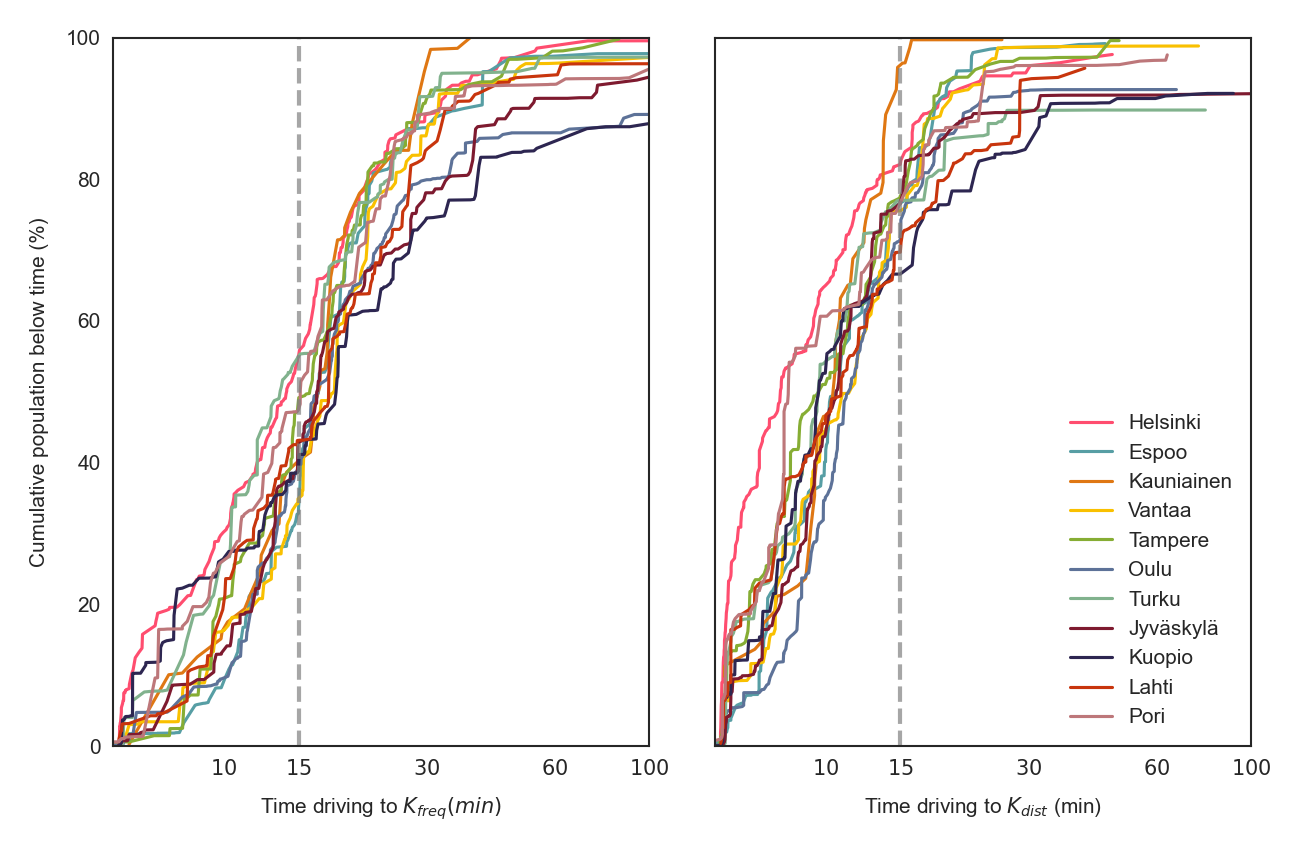

In [4]:
fig, subplots = plt.subplots(1, 2, figsize=(5, 3), dpi=300) 

cities = ['Helsinki', 
          'Espoo',
          'Kauniainen',
          'Vantaa',
          'Tampere', 
          'Oulu', 
          'Turku',
          'Jyväskylä', 
          'Kuopio', 
          'Lahti', 
          'Pori', 
          ]

# Convert the colormap to a list of colors
cmap = load_cmap('Klein')
palette_colors = [cmap(i) for i in np.linspace(0, 1, len(cities))]

for i, city in enumerate(cities):
    # Filter the data for the current city
    city_data = grid_ttm_combined[grid_ttm_combined['city'] == city]

    # Calculate the CDF for the travel time frequency
    freq_data = city_data[['car_tt_kfreq', 'popu']].sort_values(by='car_tt_kfreq')
    freq_cdf = np.cumsum(freq_data['popu']) / freq_data['popu'].sum() * 100  # Convert to percentage
    subplots[0].plot(freq_data['car_tt_kfreq'], freq_cdf, label=city, color=palette_colors[i], linewidth=0.75)

    # Calculate the CDF for the travel time distance
    dist_data = city_data[['car_tt_kdist', 'popu']].sort_values(by='car_tt_kdist')
    dist_cdf = np.cumsum(dist_data['popu']) / dist_data['popu'].sum() * 100  # Convert to percentage
    subplots[1].plot(dist_data['car_tt_kdist'], dist_cdf, label=city, color=palette_colors[i], linewidth=0.75)

# Set log scale for x-axis like in the target figure
subplots[0].set_xscale('log')
subplots[1].set_xscale('log')

# Set limits for the x-axis and y-axis to match target
subplots[0].set_xlim(5.5, 100)  
subplots[1].set_xlim(5.5, 100)
subplots[0].set_ylim(0, 100)
subplots[1].set_ylim(0, 100)

# Customize x-axis ticks to show 10^0, 10^1, 10^2
x_ticks = [10, 15, 30, 60, 100]
x_labels = ['$10$', '$15$', '$30$', '$60$', '$100$']
y_ticks = [0, 20, 40, 60, 80, 100]
subplots[0].set_xticks(x_ticks)
subplots[0].set_xticklabels(x_labels, fontsize=5)
subplots[0].set_yticks(y_ticks)
subplots[0].set_yticklabels(y_ticks, fontsize=5)
subplots[1].set_xticks(x_ticks)
subplots[1].set_xticklabels(x_labels, fontsize=5)
subplots[1].set_yticklabels('', fontsize=5)

# Add legend positioned like in target figure
# subplots[0].legend(loc='lower right', fontsize=12, frameon=False)
subplots[1].legend(loc='lower right', fontsize=5, frameon=False)

# Add a vertical line at 15 minutes
subplots[0].axvline(15, color='gray', linestyle='--', alpha=0.7, linewidth=1)
subplots[1].axvline(15, color='gray', linestyle='--', alpha=0.7, linewidth=1)

# Add labels to the axes - match target figure style
subplots[0].set_xlabel('Time driving to $K_{freq} (min)$', fontsize=5)
subplots[1].set_xlabel('Time driving to $K_{dist}$ (min) ', fontsize=5)
subplots[0].set_ylabel('Cumulative population below time (%)', fontsize=5)

# # Remove top and right spines for cleaner look
for ax in subplots:
    ax.spines['top'].set_linewidth(0.5)
    ax.spines['right'].set_linewidth(0.5)
    ax.spines['bottom'].set_linewidth(0.5)
    ax.spines['left'].set_linewidth(0.5)

    ax.tick_params(axis='both', which='major', pad=1, width=0.5, length=2)
plt.tight_layout()


# Adjust layout to prevent legend cutoff
plt.tight_layout()
plt.subplots_adjust(right=0.85)  # Make room for legend

plt.show()

## Fig 1d: City-level comparison of the population share achieving 15-minute access

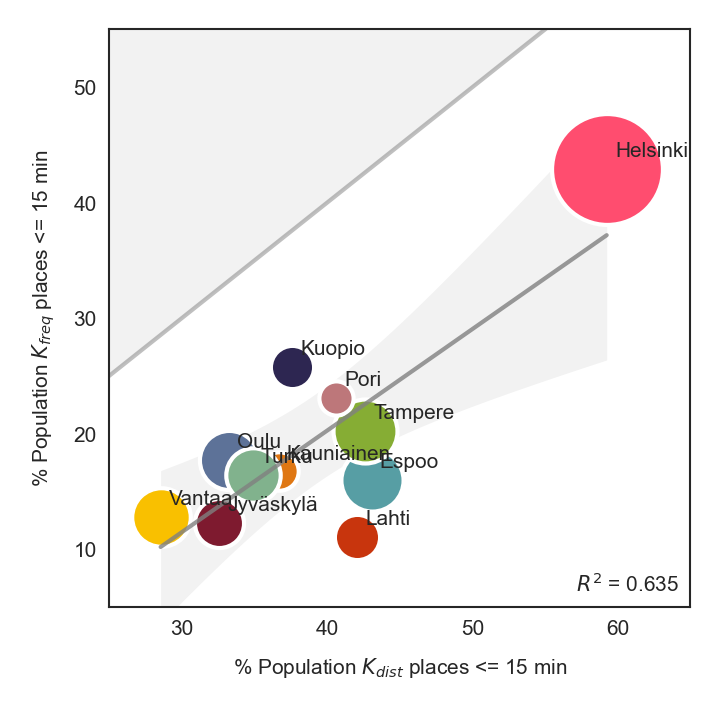

In [5]:

# Create figure
fig, ax = plt.subplots(figsize=(2.5, 2.5),dpi=300)

# Select cities to plot (major Finnish cities)
cities = ['Helsinki', 
          'Espoo',
          'Kauniainen',
          'Vantaa',
          'Tampere', 
          'Oulu', 
          'Turku',
          'Jyväskylä', 
          'Kuopio', 
          'Lahti', 
          'Pori', 
          ]

# Normalize qK values for colormap
norm = Normalize(vmin=0.6, vmax=0.7)

# Filter data for selected cities and aggregate by city
city_summary = []
for city in cities:
    city_data = grid_ttm_combined[(grid_ttm_combined['city'] == city) 
                                     ]
    if len(city_data) > 0:
        # Calculate % population accessible to K_freq places in 15 min
        pct_kfreq_15min = (city_data[city_data['pt_tt_kfreq'] <= 15]['popu'].sum() / 
                           city_data['popu'].sum() * 100)
        
        # Calculate % population accessible to K_dist places in 15 min  
        pct_kdist_15min = (city_data[city_data['pt_tt_kdist'] <= 15]['popu'].sum() / 
                           city_data['popu'].sum() * 100)
        
        # Get total population (for bubble size)
        total_pop = city_data['popu'].sum()
        
        
        city_summary.append({
            'city': city,
            'pct_kfreq': pct_kfreq_15min,
            'pct_kdist': pct_kdist_15min,
            'population': total_pop,
        })

# Convert to DataFrame for easier plotting
import pandas as pd
city_df = pd.DataFrame(city_summary)

# Load miami2 colormap
cmap = load_cmap('Klein')

# Convert the colormap to a list of colors based on number of cities
palette_colors = [cmap(i) for i in np.linspace(0, 1, len(cities))]

# Create a mapping from city city to color
city_color_map = {city: palette_colors[i] for i, city in enumerate(cities)}

# Create scatter plot with bubble sizes and colors
for idx, row in city_df.iterrows():
    ax.annotate(
        row['city'],
        (row['pct_kdist'], row['pct_kfreq']),
        fontsize=5,
        ha='left',
        va='bottom',
        xytext=(2, 2),
        textcoords='offset points'
    )
    ax.scatter(row['pct_kdist'], row['pct_kfreq'], 
               s=row['population']/1000,  # Scale population for bubble size
               c=[city_color_map[row['city']]],  # Color based on city order
               alpha=1, 
               edgecolors='w', 
               linewidth=1)


# Add diagonal reference line (y=x)
max_val = max(ax.get_xlim()[1], ax.get_ylim()[1])
ax.plot([0, 100], [0, 100], 'gray', linestyle='-', alpha=0.5, linewidth=1)
ax.fill_between([0, 100], [0, 100], [100, 100], color='gray', alpha=0.1, linewidth=0, zorder=0)

# Add linear regression line with confidence interval
from scipy.stats import linregress
import numpy as np

slope, intercept, r_value, p_value, std_err = linregress(city_df['pct_kdist'], city_df['pct_kfreq'])
x_line = np.linspace(city_df['pct_kdist'].min(), city_df['pct_kdist'].max(), 100)
y_line = slope * x_line + intercept

# Calculate confidence interval (95%)
from scipy import stats
from matplotlib.patches import Patch
n = len(city_df)
t = stats.t.ppf(0.975, n-2)  # 95% confidence interval
se = np.sqrt(np.sum((city_df['pct_kfreq'] - (slope * city_df['pct_kdist'] + intercept))**2) / (n-2))
margin = t * se * np.sqrt(1/n + (x_line - city_df['pct_kdist'].mean())**2 / np.sum((city_df['pct_kdist'] - city_df['pct_kdist'].mean())**2))

# Plot confidence interval
ax.fill_between(x_line, y_line - margin, y_line + margin, color='gray', alpha=0.1, linewidth=0, zorder=0)

# Plot regression line
ax.plot(x_line, y_line, color='gray', linewidth=1, alpha=0.8)

# Set axis labels

ax.set_xlabel('% Population $K_{dist}$ places <= 15 min', fontsize=5)
ax.set_ylabel('% Population $K_{freq}$ places <= 15 min', fontsize=5)

ax.set_xticks(np.arange(30, 61, 10))
ax.set_yticks(np.arange(10, 51, 10))
ax.set_xticklabels(np.arange(30, 61, 10), fontsize=5)
ax.set_yticklabels(np.arange(10, 51, 10), fontsize=5)

# Set axis limits
ax.set_xlim(25, 65)
ax.set_ylim(5, 55)

# Add R² annotation in lower right
r_squared = r_value**2
ax.text(0.98, 0.02, f'$R^2$ = {r_squared:.3f}', 
        transform=ax.transAxes, fontsize=5, 
        ha='right', va='bottom',
        # bbox=dict(boxstyle='round,pad=0.5', facecolor='white', edgecolor='gray', alpha=0.8))
)

ax.spines['top'].set_linewidth(0.5)
ax.spines['right'].set_linewidth(0.5)
ax.spines['bottom'].set_linewidth(0.5)
ax.spines['left'].set_linewidth(0.5)

ax.tick_params(axis='both', which='major', pad=1, width=0.5, length=2)

# plt.savefig('figures/travel_time-scatter.svg')
plt.show()

## Fig 1e-g: Travel time differences across local POI density deciles

In [6]:
ttm_gid9 = pd.read_csv(data_dir / 'ttm_gid9.csv')

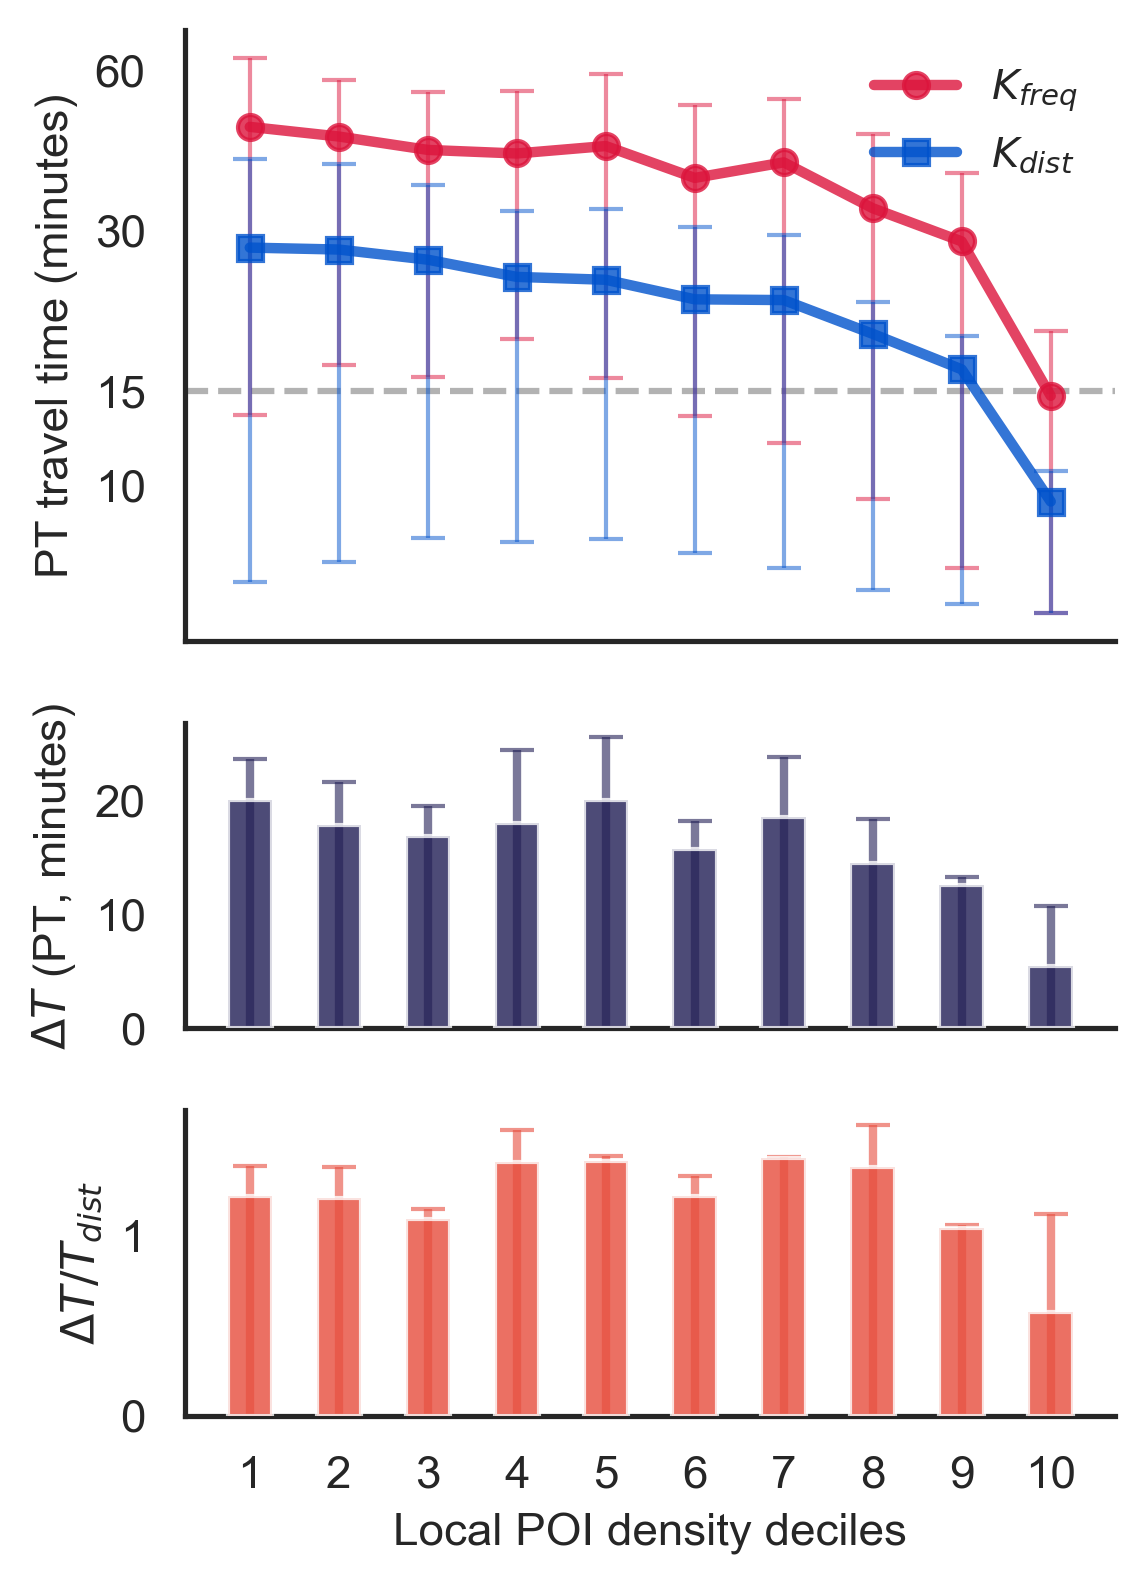

In [7]:
# Create a stacked vertical plot with 3 subplots
ttm_gid9['poi_deciles'] = pd.qcut(ttm_gid9['log_poi'], q=10, duplicates='drop')

# Aggregate all metrics by deciles
plot_data = ttm_gid9.groupby('poi_deciles', observed=True).agg({
    'pt_tt_kfreq': ['mean', lambda x: x.quantile(0.25), lambda x: x.quantile(0.75)],
    'pt_tt_kdist': ['mean', lambda x: x.quantile(0.25), lambda x: x.quantile(0.75)],
    'pt_tt_diff': ['mean', lambda x: x.quantile(0.25), lambda x: x.quantile(0.75)],
    # 'log_pt_diff': ['mean', lambda x: x.quantile(0.25), lambda x: x.quantile(0.75)],
    # 'log_rg_diff': ['mean', lambda x: x.quantile(0.25), lambda x: x.quantile(0.75)],
    'perc_pt_diff': ['mean', lambda x: x.quantile(0.25), lambda x: x.quantile(0.75)],
    'log_poi': 'mean'
}).reset_index()

# Flatten column citys
plot_data.columns = ['poi_deciles', 
                     'kfreq_mean', 'kfreq_p25', 'kfreq_p75',
                     'kdist_mean', 'kdist_p25', 'kdist_p75',
                     'pt_diff_mean', 'pt_diff_p25', 'pt_diff_p75',
                    #  'log_pt_diff_mean', 'log_pt_diff_p25', 'log_pt_diff_p75',
                    #  'rg_diff_mean', 'rg_diff_p25', 'rg_diff_p75',
                    'perc_pt_diff_mean', 'perc_pt_diff_p25', 'perc_pt_diff_p75',
                     'log_poi_mean']

# Create decile position mapping
decile_categories = plot_data['poi_deciles'].cat.categories
decile_positions = {dec: i+1 for i, dec in enumerate(decile_categories)}
plot_data['decile_pos'] = plot_data['poi_deciles'].map(decile_positions)

x_positions = plot_data['decile_pos'].astype(int)

# Create stacked subplots with height ratios (ax1 taller, ax2 and ax3 shorter)
fig, axes = plt.subplots(3, 1, figsize=(4, 6), sharex=True, 
                         gridspec_kw={'height_ratios': [2, 1, 1]}, dpi=300)

# Subplot 1: PT travel time (both K-freq and K-dist)
ax1 = axes[0]
kfreq_mean = plot_data['kfreq_mean']
kfreq_err = [np.abs(kfreq_mean - plot_data['kfreq_p25']).values,
             np.abs(plot_data['kfreq_p75'] - kfreq_mean).values]
ax1.plot(x_positions, kfreq_mean, color='#DC143C', linewidth=2.5, marker='o', 
         markersize=6, label='$K_{freq}$', alpha=0.8, zorder=3)
ax1.errorbar(x_positions, kfreq_mean, yerr=kfreq_err, fmt='none',
             ecolor='#DC143C', elinewidth=1, capsize=4, alpha=0.5, zorder=2)

kdist_mean = plot_data['kdist_mean']
kdist_err = [np.abs(kdist_mean - plot_data['kdist_p25']).values,
             np.abs(plot_data['kdist_p75'] - kdist_mean).values]
ax1.plot(x_positions, kdist_mean, color='#0052CC', linewidth=2.5, marker='s', 
         markersize=6, label='$K_{dist}$', alpha=0.8, zorder=3)
ax1.errorbar(x_positions, kdist_mean, yerr=kdist_err, fmt='none',
             ecolor='#0052CC', elinewidth=1, capsize=4, alpha=0.5, zorder=2)

ax1.set_yscale('log')
ax1.set_yticks([10, 15, 30, 60])
ax1.set_yticklabels(['10', '15', '30', '60'])
ax1.set_ylabel('PT travel time (minutes)', fontsize=11)
ax1.legend(fontsize=10, loc='upper right', frameon=False)
ax1.axhline(y=15, color='gray', linestyle='--', linewidth=1.5, alpha=0.6, zorder=1)
# ax1.grid(axis='y', alpha=0.3)

# Subplot 2: PT difference (not log scaled)
ax2 = axes[1]
pt_diff_mean = plot_data['pt_diff_mean']
pt_diff_err = [np.abs(pt_diff_mean - plot_data['pt_diff_p25']).values,
                           np.abs(plot_data['pt_diff_p75'] - pt_diff_mean).values]
ax2.bar(x_positions, pt_diff_mean, width=0.5, color='#211E55', alpha=0.8, zorder=3)
ax2.errorbar(x_positions, pt_diff_mean, yerr=pt_diff_err, fmt='none',
                         ecolor='#211E55', elinewidth=2, capsize=4, alpha=0.6, zorder=2)
ax2.set_ylabel(r'$\Delta{T}$ (PT, minutes)', fontsize=11)
# ax2.legend(['PT difference'], fontsize=10, loc='upper left')
# ax2.grid(axis='y', alpha=0.3)

# Subplot 3: Radius of gyration difference (log scaled)
ax3 = axes[2]
# Subplot 2: Radius of gyration difference (log scaled) - BOTTOM RIGHT
rg_diff_mean = plot_data['perc_pt_diff_mean']
rg_diff_err = [np.abs(rg_diff_mean - plot_data['perc_pt_diff_p25']).values,
               np.abs(plot_data['perc_pt_diff_p75'] - rg_diff_mean).values]
ax3.bar(x_positions, rg_diff_mean, width=0.5, color='#E74C3C', alpha=0.8, zorder=3)
ax3.errorbar(x_positions, rg_diff_mean, yerr=rg_diff_err, fmt='none',
             ecolor='#E74C3C', elinewidth=2, capsize=4, alpha=0.6, zorder=2)
ax3.set_ylabel(r'$\Delta{T} / T_{dist}$', fontsize=11)
ax3.set_xlabel('Local POI density deciles', fontsize=11)
ax3.set_xticks(np.arange(1, 11, 1))
# ax3.legend(['RG difference'], fontsize=10, loc='upper left')
# ax3.grid(axis='y', alpha=0.3)

plt.xticks(np.arange(1, 11, 1))

for ax in axes:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

# plt.tight_layout()
# plt.savefig("figures/delta-time.svg")
plt.show()